### 0. Loading Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import pickle

# NLP Pre-Processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import KeyedVectors

# Emoji tranlation
import demoji

# Rule Based Sentiment Detection
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PegahMaham_8pg0uam\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

C:\Users\PegahMaham_8pg0uam\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
df0 = pd.read_csv("airline_tweets_split.csv", index_col="Unnamed: 0")
df0=df0[['airline_sentiment','text', 'purpose']]
df0.columns,df0.shape

(Index(['airline_sentiment', 'text', 'purpose'], dtype='object'), (14640, 3))

## Content
0. Data and Libraries Load
1. Text Preprocessing
  1. Behind the Code: Translating Emoticons to Text
  2. Behind the Code: Pre-Processing (Cleaning, Removal of Stop Words, Lemmatisation)
  3. Behind the Code: Rule-Based Sentiment Analyser VADER
    1. Examples of most positive and most negative read tweets
    2. Examples of Misjudgement
  4. Behind the Code: What top "(2-3)-grams" are the most common in the data?
  5. Behind the Code: Getting an Intuition for fastText's Word Embedding
    1. Most similar words
    2. Similarity of words to "happy" and "sad" as proxies for positive and negative sentiment
2. Classification Model
  1. Creating Test and Train Set with Various Feature Sets
  2. Optimizing Hyperparameters for most Promising Classification Models
  3. Evaluation

## 1. Text Preprocessing

### *Behind the Code: Translating Emoticons to Text*

In [4]:
# 2 examples
demoji.download_codes()
demoji.findall("😠"), demoji.findall("😊")

... OK (Got response in 0.32 seconds)
Writing emoji data to C:\Users\PegahMaham_8pg0uam\.demoji\codes.json ...
... OK


({'😠': 'angry face'}, {'😊': 'smiling face with smiling eyes'})

In [5]:
dfSmiley=df0[['airline_sentiment','text', 'purpose']]
dfSmiley.loc[:,"text+"] = dfSmiley["text"].apply(lambda x: x+" "+(" ".join(list(demoji.findall(x).values())+[" "])[0:]))
dfSmiley.loc[:,"emoji"] = dfSmiley["text"].apply(lambda x: list(demoji.findall(x).values()))
dfSmiley.loc[:,"testlength"]=dfSmiley["emoji"].apply(lambda x: len(x))
dfSmiley[dfSmiley.testlength!=0].head(2)

,airline_sentiment,text,purpose,text+,emoji,testlength
18,positive,I ❤️ flying @VirginAmerica. ☺️👍,train,I ❤️ flying @VirginAmerica. ☺️👍 red heart thumbs up smiling face,"[red heart, thumbs up, smiling face]",3
24,negative,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,train,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet pouting face,[pouting face],1


In [6]:
def getTokens(df):
    '''This function takes a dataframe with a "text" column and
    returns a corpus_gensim and a corpus_bow column for the corresponding feature extraction methods.'''
    ##### General Pre-Processing #####
    # Emojis to Words
    df.loc[:,"text0"] =df["text"].apply(lambda x: x+" "+(" ".join(list(demoji.findall(x).values())+[" "])[0:]))
     # Remove URLs
    df.loc[:,"text0"] = df['text0'].map(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', x))
    # Remove usernames
    df.loc[:,"text0"] = df['text0'].map(lambda x: re.sub('@[^\s]+', '', x))    
    # Making everything lowercase
    df.loc[:,"text0"] = df["text0"].map(lambda x: x.lower())    
    
    ##### Gensim Pre-Processing #####
    # Delete "'s" at the end of words
    df.loc[:,"corpus_gensim"] = df['text0'].map(lambda x: re.sub("' ", " ", x))
    # Keep only letters and "'s" within words (e.g. "Don't" is known in pre-trained gensim model)
    df.loc[:,"corpus_gensim"] = df['corpus_gensim'].map(lambda x: re.sub("[^a-zA-Z']", ' ', x))
    # Create list of words
    df.loc[:,"corpus_gensim"] = df["corpus_gensim"].apply(lambda x: x.split(' '))
    
    ##### Bag-of-Word Pre-Processing #####
    # Convert e.g. "don't" to "dont" to lateron understand all versions as one
    df.loc[:,"corpus_bow"] = df['text0'].map(lambda x: re.sub("'", "", x))
    # Get rid of all punctuation
    df.loc[:,"corpus_bow"] = df['corpus_bow'].map(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    #splitting the sentence into words
    df.loc[:,"corpus_bow"] = df["corpus_bow"].map(lambda x: x.split())
    # delete stop words (modified) and stem the remaining words
    ps = PorterStemmer()
    stopwords_all = (stopwords.words('english'))
    # Useful stopwords are hand-selected and kept
    useful_stop_words = ['no','nor','only','any','not','don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    stopwords0 = [word for word in stopwords_all if not word in useful_stop_words]
    df.loc[:,"corpus_bow"] = df["corpus_bow"].map(lambda x:[ps.stem(word) for word in x if not word in stopwords0])
    # Join back to create string
    df.loc[:,"corpus_bow"] = df["corpus_bow"].map(lambda x: ' '.join(x))
    return(df)

### *Behind the Code: Pre-Processing (Cleaning, Removal of Stop Words, Lemmatisation)*

In [7]:
dfT=df0.copy()
dfT=getTokens(dfT)
dfT.head(5)

,airline_sentiment,text,purpose,text0,corpus_gensim,corpus_bow
0,neutral,@VirginAmerica What @dhepburn said.,train,what said.,"[, what, , said, , , ]",said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,train,plus you've added commercials to the experience... tacky.,"[, plus, you've, added, commercials, to, the, experience, , , , tacky, , , ]",plu youv ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,train,i didn't today... must mean i need to take another trip!,"[, i, didn't, today, , , , must, mean, i, need, to, take, another, trip, , , ]",didnt today must mean need take anoth trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",test,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[, it's, really, aggressive, to, blast, obnoxious, , entertainment, , in, your, guests, faces, , amp, , they, have, little, recourse, , ]",realli aggress blast obnoxi entertain guest face amp littl recours
4,negative,@VirginAmerica and it's a really big bad thing about it,train,and it's a really big bad thing about it,"[, and, it's, a, really, big, bad, thing, about, it, , ]",realli big bad thing


In [8]:
# Add a feature with a rule-based sentiment analyser "VADER"
analyser = SentimentIntensityAnalyzer()
dfT["VADER"]=dfT["text0"].map(lambda x :analyser.polarity_scores(x)["compound"])
# Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. 
# Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

### *Behind the Code: Rule-Based Sentiment Analyser VADER*
#### *1. Examples of most positive and most negative read tweets*

In [9]:
dfT.nlargest(3, 'VADER')

,airline_sentiment,text,purpose,text0,corpus_gensim,corpus_bow,VADER
7139,positive,@JetBlue hahah 😂👌👌👌 love flying jet blue tho!! http://t.co/7VeE44MACM,train,hahah 😂👌👌👌 love flying jet blue tho!! face with tears of joy ok hand,"[, , hahah, , , , , , love, flying, jet, blue, tho, , , , face, with, tears, of, joy, ok, hand, , ]",hahah love fli jet blue tho face tear joy ok hand,0.9866
13794,negative,@AmericanAir that luggage you forgot...#mia.....he just won an oscar😄💝💝💝,train,that luggage you forgot...#mia.....he just won an oscar😄💝💝💝 heart with ribbon grinning face with smiling eyes,"[, that, luggage, you, forgot, , , , mia, , , , , he, just, won, an, oscar, , , , , heart, with, ribbon, grinning, face, with, smiling, eyes, , ]",luggag forgot mia won oscar heart ribbon grin face smile eye,0.9855
238,positive,@VirginAmerica hahaha 😂@VirginAmerica YOU GUYS ARE AMAZING. I LOVE YOU GUYS!!!💗,test,hahaha 😂 you guys are amazing. i love you guys!!!💗 face with tears of joy growing heart,"[, hahaha, , , you, guys, are, amazing, , i, love, you, guys, , , , , face, with, tears, of, joy, growing, heart, , ]",hahaha guy amaz love guy face tear joy grow heart,0.9835


In [10]:
dfT.nsmallest(3, 'VADER')

,airline_sentiment,text,purpose,text0,corpus_gensim,corpus_bow,VADER
11702,positive,"@USAirways YOU ARE THE BEST AIRWAYS!!!!!!!!!! FOLLOW ME BACK, PLEASE 🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏😢😢😢😢😢😢😢😢🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏",train,"you are the best airways!!!!!!!!!! follow me back, please 🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏😢😢😢😢😢😢😢😢🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏 crying face folded hands","[, you, are, the, best, airways, , , , , , , , , , , follow, me, back, , please, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , crying, face, folded, hands, , ]",best airway follow back pleas cri face fold hand,-0.9704
1214,negative,"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!",train,"is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, you're not that bad!","[, is, the, worst, , worst, reservation, policies, , worst, costumer, service, , worst, worst, worst, , congrats, , , you're, not, that, bad, , , ]",worst worst reserv polici worst costum servic worst worst worst congrat your not bad,-0.9668
5266,neutral,@SouthwestAir microsecond too Late Flight so very very sad 😂😂😂😂😂😭😭😭😭😢😢😢😢,train,microsecond too late flight so very very sad 😂😂😂😂😂😭😭😭😭😢😢😢😢 face with tears of joy crying face loudly crying face,"[, microsecond, too, late, flight, so, very, very, sad, , , , , , , , , , , , , , , face, with, tears, of, joy, crying, face, loudly, crying, face, , ]",microsecond late flight sad face tear joy cri face loudli cri face,-0.9554


#### *2. Examples of Misjudgement*
Tweets that are labeled different to the VADER sentiment 

In [11]:
dfT[(dfT.VADER>0.9) & (dfT.airline_sentiment=="negative")].head(3)

,airline_sentiment,text,purpose,text0,corpus_gensim,corpus_bow,VADER
752,negative,@united The bright side would be keeping the promise that was made to me. Hope you're having a good night. Thanks.,train,the bright side would be keeping the promise that was made to me. hope you're having a good night. thanks.,"[, the, bright, side, would, be, keeping, the, promise, that, was, made, to, me, , hope, you're, having, a, good, night, , thanks, , , ]",bright side would keep promis made hope your good night thank,0.9169
1072,negative,@united Thanks! I'll fill up the form as soon as I land. I don't like being duped so I hope you will appreciate my feedback &amp; will be better,train,thanks! i'll fill up the form as soon as i land. i don't like being duped so i hope you will appreciate my feedback &amp; will be better,"[, thanks, , i'll, fill, up, the, form, as, soon, as, i, land, , i, don't, like, being, duped, so, i, hope, you, will, appreciate, my, feedback, , amp, , will, be, better, , ]",thank ill fill form soon land dont like dupe hope appreci feedback amp better,0.9041
1666,negative,@united of course. But interesting how United doesn't seem to have a good sense on what's happening with flight,test,of course. but interesting how united doesn't seem to have a good sense on what's happening with flight,"[, of, course, , but, interesting, how, united, doesn't, seem, to, have, a, good, sense, on, what's, happening, with, flight, , ]",cours interest unit doesnt seem good sens what happen flight,0.9022


In [12]:
dfT[(dfT.VADER<-0.8) & (dfT.airline_sentiment=="positive")].head(3)

,airline_sentiment,text,purpose,text0,corpus_gensim,corpus_bow,VADER
1617,positive,@united thanks for updating me about the 1+ hour delay the exact second I got to ATL. 🙅🙅🙅,train,thanks for updating me about the 1+ hour delay the exact second i got to atl. 🙅🙅🙅 person gesturing no,"[, thanks, for, updating, me, about, the, , , , hour, delay, the, exact, second, i, got, to, atl, , , , , , person, gesturing, no, , ]",thank updat hour delay exact second got atl person gestur no,-0.8555
4614,positive,"@SouthwestAir What can we do to bring you back to Jackson, MS?! We miss you terribly around here. These other airlines are horrible!!",train,"what can we do to bring you back to jackson, ms?! we miss you terribly around here. these other airlines are horrible!!","[, what, can, we, do, to, bring, you, back, to, jackson, , ms, , , we, miss, you, terribly, around, here, , these, other, airlines, are, horrible, , , , ]",bring back jackson ms miss terribl around airlin horribl,-0.8617
5510,positive,@SouthwestAir I wish i would've seen this 4 hours ago!!! I WANTED TO SEE THEM TONIGHT SO BAD!!!! #CRYING,train,i wish i would've seen this 4 hours ago!!! i wanted to see them tonight so bad!!!! #crying,"[, i, wish, i, would've, seen, this, , , hours, ago, , , , i, wanted, to, see, them, tonight, so, bad, , , , , , crying, , ]",wish wouldv seen hour ago want see tonight bad cri,-0.8094


In [13]:
# This takes a couple of min
gensim_model = KeyedVectors.load_word2vec_format('crawl-300d-2M.vec')
# download from https://fasttext.cc/docs/en/english-vectors.html
# T. Mikolov, E. Grave, P. Bojanowski, C. Puhrsch, A. Joulin. Advances in Pre-Training Distributed Word Representations

In [14]:
def tweet_vectorizer(tweet, model):
    '''This function creates the embedding for the whole tweet by averaging over each of the
    the word embeddings.'''
    sent_vec =[]
    numw = 0
    for word in tweet:
        try:
            if numw == 0:
                sent_vec = model[word]
            else:
                sent_vec = np.add(sent_vec, model[word])
            numw+=1
        except:
            pass
    if len(sent_vec)==0:
        return (np.asarray([0]*300))
    return (np.asarray(sent_vec) / numw)

def getFeatures(df, tfidf_dim, ngram, model):
    '''This function creates word embeddings in two ways 
    and adds those embeddings to the dataframe.'''
    
    ## 1. Relative Bag-of-Words (tf-idf) ##
    cv = CountVectorizer(max_features = tfidf_dim, ngram_range=ngram)
    # using relative word counts instead of absolute ones
    tfidf_transformer = TfidfTransformer()
    bow = cv.fit_transform(df["corpus_bow"]).toarray()
    tfidf = tfidf_transformer.fit_transform(bow).toarray()
    tfidf=list(tfidf)
    df["tfidf"]=tfidf
    # Adding new columns, a column for each dimension of word vector
    for i in range(tfidf_dim):
            df[f"tfidf_{str(i)}"] = df["tfidf"].apply(lambda x : x[i])
        
    ## 2. pre-trained FastText Word Embedding
    df.loc[:,"embedded_tweet_vector"]=df["corpus_gensim"].apply(lambda x: tweet_vectorizer(x, model))
    # Adding new columns, a column for each dimension of word vector
    for i in range(300):
        df.loc[:,f"gensim_{str(i)}"] = df["embedded_tweet_vector"].apply(lambda x : x[i])
    return(df)

In [15]:
dfF=dfT.copy()
# Using top 600 (1-3)-grams
dfF=getFeatures(dfF,600,(1,3),gensim_model)

### *Behind the Code: What top "(2-3)-grams" are the most common in the data?*

In [16]:
cv = CountVectorizer(max_features = 20, ngram_range=(2,3))
bow = cv.fit_transform(dfT["corpus_bow"]).toarray()
dict(zip(cv.get_feature_names(),np.asarray(bow.sum(axis=0)).ravel()))

{'book problem': 145,
 'call back': 117,
 'cancel flight': 434,
 'cancel flight flight': 151,
 'cancel flightl': 526,
 'cancel flightl flight': 138,
 'cant get': 119,
 'custom servic': 570,
 'fleet fleek': 146,
 'flight book': 110,
 'flight cancel': 235,
 'flight cancel flightl': 154,
 'flight delay': 164,
 'flight flight': 169,
 'flightl flight': 138,
 'hold hour': 133,
 'late flight': 250,
 'late flightr': 158,
 'miss connect': 113,
 'no one': 131}

### *Behind the Code: Getting an Intuition for fastText's Word Embedding*
#### *1. Most similar words*

In [17]:
print(gensim_model.most_similar('disappointed'))

[('dissapointed', 0.8315879702568054), ('dissappointed', 0.826554536819458), ('disapointed', 0.7895401120185852), ('disapppointed', 0.7551141977310181), ('diappointed', 0.7392339706420898), ('disppointed', 0.7367231845855713), ('disheartened', 0.7293992638587952), ('disappointing', 0.7167659997940063), ('disapponted', 0.7113564014434814), ('dismayed', 0.7051864862442017)]


In [18]:
print(gensim_model.most_similar('didnt'))

[('wouldnt', 0.849150538444519), ('didint', 0.8336474895477295), ('couldnt', 0.8300750255584717), ('Didnt', 0.8010633587837219), ('diddnt', 0.7912237644195557), ('dont', 0.7839059829711914), ('doesnt', 0.7829113006591797), ('dident', 0.7668754458427429), ('ddint', 0.7568346261978149), ('wasnt', 0.7561928033828735)]


In [19]:
print(gensim_model.most_similar('obnoxious'))

[('annoying', 0.7876083850860596), ('obnoxiously', 0.7467677593231201), ('abnoxious', 0.7411515712738037), ('insufferable', 0.7209519147872925), ('irritating', 0.7104653120040894), ('Obnoxious', 0.7014889717102051), ('boorish', 0.6725412607192993), ('obnoxiousness', 0.6718343496322632), ('OBNOXIOUS', 0.6691552400588989), ('overbearing', 0.66034996509552)]


#### *2. Similarity of words to "happy" and "sad" as proxies for positive and negative sentiment*

In [20]:
def word_distance(word1,word2,word3):
    '''This function compares the distance in the embedding space 
    between two words and another word (word1)'''
    list1 = gensim_model[word1]
    list2 = gensim_model[word2]
    list3 = gensim_model[word3]
    diff12 = [a - b for a, b in zip(list1, list2)]
    diff13 = [a - b for a, b in zip(list1, list3)]
    diff12=map(abs, diff12)
    diff13=map(abs, diff13)
    print(f'The distance between the word "{word1}" and the word "{word2}" is', sum(diff12))
    print(f'The distance between the word "{word1}" and the word "{word3}" is', sum(diff13))
    print("\n")

In [21]:
# Does it have flight and task related "understanding"
word_distance("late","punctual","delayed")
word_distance("thank","happy","sad")
# Does it "understand" colloquial language?
word_distance("psyched","happy","sad")
word_distance("bummer","happy","sad")

The distance between the word "late" and the word "punctual" is 71.43720005825162
The distance between the word "late" and the word "delayed" is 54.68210012000054


The distance between the word "thank" and the word "happy" is 64.1974000679329
The distance between the word "thank" and the word "sad" is 68.20630018785596


The distance between the word "psyched" and the word "happy" is 59.77450000401586
The distance between the word "psyched" and the word "sad" is 67.4953998811543


The distance between the word "bummer" and the word "happy" is 59.47830008715391
The distance between the word "bummer" and the word "sad" is 51.9664000896737




#### Potential Additional Features
Length, Explanation Marks, Question Marks

# 2. Training Classification Models

### Creating test and train set with various feature sets

In [22]:
df_train=dfF[dfF.purpose=="train"]
df_test=dfF[dfF.purpose=="test"]
y_train = df_train[["airline_sentiment"]]
y_test = df_test[["airline_sentiment"]]
gensim_columns=[f"gensim_{i}" for i in range(300)]
tfidf_columns=[f"tfidf_{i}" for i in range(600)]
# Having tested these combinations of features, the full data set performs 
# best and is used for optimizing hyperparameters
X_train_gensim = df_train[gensim_columns]
X_test_gensim = df_test[gensim_columns]
X_train_tfidf = df_train[tfidf_columns]
X_test_tfidf = df_test[tfidf_columns]
X_train_both = df_train[tfidf_columns+gensim_columns]
X_test_both = df_test[tfidf_columns+gensim_columns]
X_train_all = df_train[tfidf_columns+gensim_columns+["VADER"]]
X_test_all = df_test[tfidf_columns+gensim_columns+["VADER"]]

In [23]:
# unbalanced classes, but still ok. Decided against over- or undersampling.
y_train.airline_sentiment.value_counts(),y_test.airline_sentiment.value_counts()

(negative    7342
 neutral     2479
 positive    1891
 Name: airline_sentiment, dtype: int64,
 negative    1836
 neutral     620 
 positive    472 
 Name: airline_sentiment, dtype: int64)

### Optimizing Hyperparameters for most Promising Classification Models
In this case, a neural net and regularized logistic regression 

In [24]:
def getLogitHyperparameters(X_train,X_test):
    '''This function runs Cross Validations for regularization parameters
    in a Logistic Regression and returns the accuracy and parameters for the best model.
    '''
    # Set Parameter Space
    penalty=["l1","l2"]
    C = [0.01,0.1,1,2]
    hyperparameters = dict(C=C, penalty=penalty)
    logistic=LogisticRegression(solver='liblinear') # regularization is applied by default
    clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)
    best_model = clf.fit(X_train, y_train.values.ravel())
    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best Regularization:', best_model.best_estimator_.get_params()['C'])
    accuracy_best_logit=best_model.score(X_test,y_test.values.ravel())
    print(f"Test Accuracy Best Logit: {accuracy_best_logit}")

In [25]:
getLogitHyperparameters(X_train_all,X_test_all)
# l2 (Ridge Regularization) with c=1 are the default settings here anyway.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.9min finished


Best Penalty: l2
Best Regularization: 1
Test Accuracy Best Logit: 0.8121584699453552


In [34]:
def getNNHyperparameters(X_train,X_test, hls,alpha):
    '''This function runs a Multi-layer Perceptron (Neural Net) with hidden-layer size hls
    and a regularization parameter alpha on the train set
    and returns the respective accuracy on the test set.'''
    nn=MLPClassifier(hidden_layer_sizes=hls,alpha=alpha,max_iter=10,random_state=0)
    nn.fit(X_train, y_train.values.ravel())
    accuracy_nn=nn.score(X_test,y_test.values.ravel())
    print(f"Test Accuracy NN:{accuracy_nn} for Hidden Layers{hls}, alpha={alpha}")

In [35]:
# This takes some time, other hidden-layer-sizes have been tested but did not improve the results
for alpha in [0.01,0.1,0.2]:
    for hls in [[600]]:
        getNNHyperparameters(X_train_all,X_test_all,hls,alpha)

C:\Users\PegahMaham_8pg0uam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test Accuracy NN:0.8111338797814208 for Hidden Layers[600], alpha=0.01


C:\Users\PegahMaham_8pg0uam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test Accuracy NN:0.8135245901639344 for Hidden Layers[600], alpha=0.1


C:\Users\PegahMaham_8pg0uam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test Accuracy NN:0.8097677595628415 for Hidden Layers[600], alpha=0.2


### Evaluation
#### Final Test Accuracy
- 0.814 for Multi-Layer Perceptron, a simple neural net with one hidden layers a 600 nodes and alpha=0.1 for regularization.
- 0.812 for Regularized Logistic Regression with c=1 for regularization and L2 penalty.

Both models use the tf-idf features, the fastText word embedding features and the VADER rule-based sentiment scores.

In [36]:
null_rate = y_test["airline_sentiment"].value_counts().max()/len(y_test)
print(f"The null rate for 'guessing' (always predicting the most dominant class (here 'negative')) is {null_rate}")

The null rate for 'guessing' (always predicting the most dominant class (here 'negative')) is 0.6270491803278688


#### Confusion Matrix for the results of the Top Models

C:\Users\PegahMaham_8pg0uam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

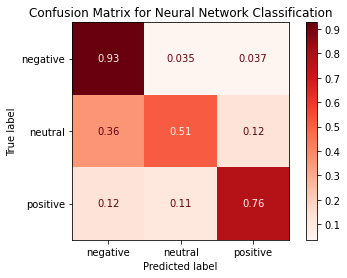

In [39]:
plt.figure()
nn=MLPClassifier(hidden_layer_sizes=[600],alpha=0.1,max_iter=10,random_state=0)
nn.fit(X_train_all, y_train.values.ravel())
plot_confusion_matrix(nn, X_test_all, y_test.values.ravel(),
                                 cmap=plt.cm.Reds,
                                 normalize='true')
plt.title("Confusion Matrix for Neural Network Classification")
plt.show();

<Figure size 432x288 with 0 Axes>

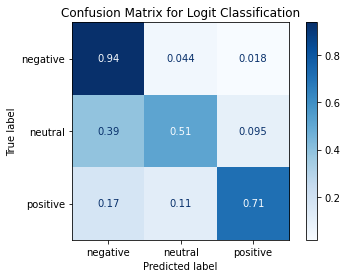

In [38]:
log = LogisticRegression(solver='liblinear')
log.fit(X_train_all, y_train.values.ravel());
plt.figure()
plot_confusion_matrix(log, X_test_all, y_test.values.ravel(),
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title("Confusion Matrix for Logit Classification")
plt.show();

#### Conclusion
As we can see, both models classify the neutral tweets similarly well (51% correct). Overall, the neutral tweets are the hardest to classify correctly.
While the neural net performs better in predicting positive tweets (76% vs. 71% true positive rate), the logit model is slightly superior with regard to negative tweets (94% vs. 93% true negative rate).